## Построение бинароного классификатора
На основе датасета с данными о проданных подержанных автомобилях в Германии в 2016 году построим модель бинарного классификатора, который бы позволил определить была ли машина в ремонте или нет

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%capture
!wget https://www.dropbox.com/s/s1sqfsi6x7hbs28/autos_mod.csv

In [3]:
df = pd.read_csv('autos_mod.csv', encoding='iso-8859-1')
df.isnull().any()

Unnamed: 0            False
price                 False
vehicleType            True
yearOfRegistration    False
gearbox                True
powerPS               False
model                  True
kilometer             False
fuelType               True
brand                 False
notRepairedDamage      True
dtype: bool

In [4]:
del df["Unnamed: 0"]

In [7]:
df = df.drop(df[pd.isnull(df['vehicleType'])].index)
df = df.drop(df[pd.isnull(df['gearbox'])].index)
df = df.drop(df[pd.isnull(df['model'])].index)
df = df.drop(df[pd.isnull(df['fuelType'])].index)
df = df.drop(df[pd.isnull(df['notRepairedDamage'])].index)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250919 entries, 2 to 329656
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               250919 non-null  int64 
 1   vehicleType         250919 non-null  object
 2   yearOfRegistration  250919 non-null  int64 
 3   gearbox             250919 non-null  object
 4   powerPS             250919 non-null  int64 
 5   model               250919 non-null  object
 6   kilometer           250919 non-null  int64 
 7   fuelType            250919 non-null  object
 8   brand               250919 non-null  object
 9   notRepairedDamage   250919 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.1+ MB


In [9]:
df['notRepairedDamage'].unique()

array(['nein', 'ja'], dtype=object)

In [10]:
names = ['vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']
for name in names:
    df[name] = pd.factorize(df[name])[0]
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
2,1500,0,2001,0,75,0,150000,0,0,0
3,3600,0,2008,0,69,1,90000,1,1,0
4,650,1,1995,0,102,2,150000,0,2,1
5,2200,2,2004,0,109,3,150000,0,3,0
6,0,1,1980,0,50,4,40000,0,0,0


In [11]:
df = df.reset_index(drop=True)
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,1500,0,2001,0,75,0,150000,0,0,0
1,3600,0,2008,0,69,1,90000,1,1,0
2,650,1,1995,0,102,2,150000,0,2,1
3,2200,2,2004,0,109,3,150000,0,3,0
4,0,1,1980,0,50,4,40000,0,0,0


In [12]:
df['notRepairedDamage'].value_counts()

notRepairedDamage
0    225322
1     25597
Name: count, dtype: int64

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,250919.0,8386.187670,350097.671765,0.0,1600.0,3950.0,8888.0,99999999.0
vehicleType,250919.0,2.103942,1.867884,0.0,1.0,1.0,3.0,7.0
gearbox,250919.0,0.234661,0.423788,0.0,0.0,0.0,0.0,1.0
powerPS,250919.0,129.214826,61.794294,1.0,86.0,116.0,156.0,589.0
model,250919.0,47.745360,51.246943,0.0,6.0,35.0,64.0,249.0
kilometer,250919.0,123812.266110,39876.537148,5000.0,100000.0,150000.0,150000.0,150000.0
fuelType,250919.0,0.380481,0.563411,0.0,0.0,0.0,1.0,6.0
brand,250919.0,8.761050,8.181093,0.0,2.0,7.0,14.0,38.0
notRepairedDamage,250919.0,0.102013,0.302666,0.0,0.0,0.0,0.0,1.0
age,250919.0,16.549500,6.393063,2.0,12.0,16.0,20.0,69.0


<Axes: >

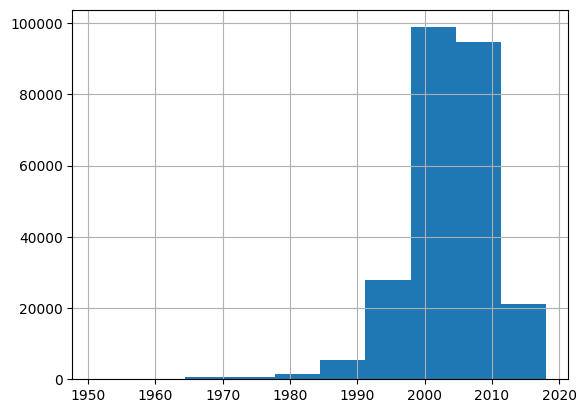

In [13]:
df['yearOfRegistration'].hist()

In [14]:
df['age'] = 2020 - df['yearOfRegistration']
del df['yearOfRegistration']
df.head()

,price,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,age
0,1500,0,0,75,0,150000,0,0,0,19
1,3600,0,0,69,1,90000,1,1,0,12
2,650,1,0,102,2,150000,0,2,1,25
3,2200,2,0,109,3,150000,0,3,0,16
4,0,1,0,50,4,40000,0,0,0,40


<Axes: >

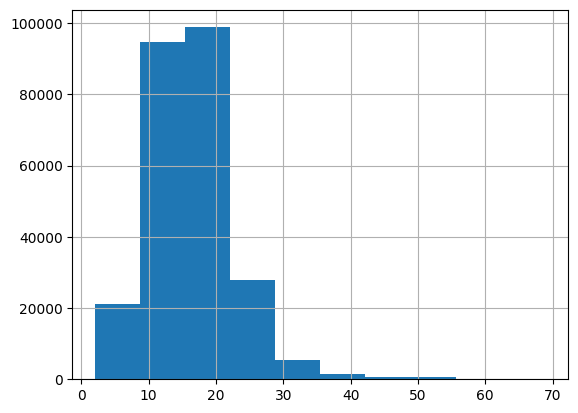

In [17]:
df['age'].hist()

In [15]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

In [18]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

In [19]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9074804718635422


In [20]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 6s 2ms/step - loss: 41.7425 - accuracy: 0.8280 - val_loss: 4.0124 - val_accuracy: 0.9003
Epoch 2/10
2008/2008 [==============================] - 4s 2ms/step - loss: 64.6218 - accuracy: 0.8246 - val_loss: 9.9284 - val_accuracy: 0.9002
Epoch 3/10
2008/2008 [==============================] - 5s 3ms/step - loss: 44.6653 - accuracy: 0.8206 - val_loss: 6.4448 - val_accuracy: 0.9005
Epoch 4/10
2008/2008 [==============================] - 4s 2ms/step - loss: 37.7731 - accuracy: 0.8186 - val_loss: 4.0167 - val_accuracy: 0.9006
Epoch 5/10
2008/2008 [==============================] - 4s 2ms/step - loss: 32.9625 - accuracy: 0.8198 - val_loss: 14.6592 - val_accuracy: 0.8554
Epoch 6/10
2008/2008 [==============================] - 5s 3ms/step - loss: 55.0687 - accuracy: 0.8412 - val_loss: 2.8992 - val_accuracy: 0.8938
Epoch 7/10
2008/2008 [==============================] - 4s 2ms/step - loss: 40.0605 - accuracy: 0.8647 - val_loss: 2.5100 - val_a